# Data Mining HW4, Problem 2

First we need to install all the necessary libraries for the project and import them.

In [ ]:
!pip install torch-geometric==2.0.1
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [4]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = "plotly_white"

import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from torch_geometric.nn import to_hetero, SAGEConv
from torch_geometric.utils import dropout_adj
from torch_sparse import SparseTensor, matmul
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader

Here we will set up the device and the initial settings using torch library.

In [5]:
torch.manual_seed(7)
device = torch.device('cpu')
if torch.cuda.is_available():
  torch.cuda.manual_seed(7)
  torch.cuda.synchronize()
  device = torch.device('cuda')
device

device(type='cpu')

Then we need to upload the dataset in the sample_data folder of google colab. And then we define the path of the data for later when we want to read the dataset.

In [6]:
movies_path = 'sample_data/movies.csv'
ratings_path = 'sample_data/ratings.csv'
links_path = 'sample_data/links.csv'
tags_path = 'sample_data/tags.csv'

Here we have two different encoders. We will use the SequenceEncoder for encoding the titles of the movies using the sentence transformer and the GenresEncoder to encode the genre of the movies.

In [7]:
class SequenceEncoder(object):
  def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
    self.device = device
    self.model = SentenceTransformer(model_name, device=device)

  @torch.no_grad()
  def __call__(self, df):
    x = self.model.encode(df.values, show_progress_bar=True, convert_to_tensor=True, device=self.device)
    return x.cpu()

In [8]:
class GenresEncoder(object):
  def __init__(self, sep='|'):
    self.sep = sep

  def __call__(self, df):
    genres = set(g for col in df.values for g in col.split(self.sep))
    mapping = {genre: i for i, genre in enumerate(genres)}

    x = torch.zeros(len(df), len(mapping))
    for i, col in enumerate(df.values):
      for genre in col.split(self.sep):
        x[i, mapping[genre]] = 1
    return x

Users and the Movies are the nodes of our GNN and the edges would be the rating  of the movie which the user gave. For instance, user id 1 rated 4 to movie id 10. This will be showed as two connected nodes of movie and user that their edge weight is 4.

In [ ]:
def load_node_csv(path, index_col, encoders=None, **kwargs):
  df = pd.read_csv(path, index_col=index_col, **kwargs)
  mapping = {index: i for i, index in enumerate(df.index.unique())}

  x = None
  if encoders is not None:
    xs = [encoder(df[col]) for col, encoder in encoders.items()]
    x = torch.cat(xs, dim=-1)

  return x, mapping

user_x, user_mapping = load_node_csv(ratings_path, index_col='userId')
movie_x, movie_mapping = load_node_csv(movies_path, index_col='movieId', encoders={'title': SequenceEncoder(), 'genres': GenresEncoder()})

Then we would load the edges (ratings) from the dataset and we use identity encoder to encode them. Also it is important to note that we would remove the ratings less than 4. Because having too much edge will not help us in the GNN cause it makes the whole data goes towards the way that all the nodes pass messages to each other and the data gets similar. Moreover, if we want to recommend a movie to someone, it makes sense to recommend a movie which we gave 4 or more than 4 as a rating to it.

Since the source and the destination of an edge have different types (one of them is user and the other one is the movies), the graph is a bipartite graph.

In [11]:
class IdentityEncoder(object):
  def __init__(self, dtype=None):
    self.dtype = dtype

  def __call__(self, df):
    return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)

In [36]:
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, encoders=None, **kwargs):
  df = pd.read_csv(path, **kwargs)
  df = df.drop(df[df.rating < 4].index)

  src = [src_mapping[index] for index in df[src_index_col]]
  dst = [dst_mapping[index] for index in df[dst_index_col]]
  edge_index = torch.tensor([src, dst])

  edge_label = None
  if encoders is not None:
    edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
    edge_label = torch.flatten(torch.cat(edge_attrs, dim=-1))

  return edge_index, edge_label


edge_index, edge_label = load_edge_csv(
  ratings_path,
  src_index_col='userId',
  src_mapping=user_mapping,
  dst_index_col='movieId',
  dst_mapping=movie_mapping,
  encoders={'rating': IdentityEncoder(dtype=torch.long)},
)

In [37]:
def print_label(my_tensor):
  for label in torch.flatten(my_tensor).tolist():
    if label > 5:
      print(label)

Since we have different node types, we would use the heterodata from geometric torch.

In [38]:
data = HeteroData()

data['user'].num_nodes = len(user_mapping)
data['user'].x = torch.eye(data['user'].num_nodes)
data['movie'].x = movie_x

data['user', 'rates', 'movie'].edge_index = edge_index
data['user', 'rates', 'movie'].edge_label = edge_label

print(data)

HeteroData(
  user={
    num_nodes=610,
    x=[610, 610]
  },
  movie={ x=[9742, 404] },
  (user, rates, movie)={
    edge_index=[2, 48580],
    edge_label=[48580]
  }
)


When we created the GNN, the edges has directions which we don't want. So we have to remove the reverse labels to make the graph undirected.

In [39]:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

In order to train our model, we need to split our data into three different sets: train set, validation set, and test set. For this matter we use RandomLinkSplit function.

In [40]:
transform = T.RandomLinkSplit(is_undirected=True, neg_sampling_ratio=0.0, edge_types=[('user', 'rates', 'movie')])
train_data, val_data, test_data = transform(data)

Here we count the number of edges for different ratings.

In [41]:
counts = torch.bincount(data['user', 'movie'].edge_label)

In [ ]:
torch.unique(data['user', 'movie'].edge_label)

In [ ]:
counts

Then we use the counts we obtained above to calculate the weights for each rate. We will use this weights for calculating the weighted rmse.

In [77]:
weight = counts.max() / counts
weight[0] = 0.5
weight[1] = 0.5
weight[2] = 0.5
weight[3] = 0.5

In [45]:
weight

tensor([0.5000, 0.5000, 0.5000,    inf, 1.0000, 2.6772])

Here we load our graph with train data set in different batches with size 128 and we 

In [46]:
def get_loader(data, is_train=True):
  edge_label_index = data["user", "rates", "movie"].edge_label_index
  edge_label = data["user", "rates", "movie"].edge_label

  loader = LinkNeighborLoader(
    data = data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2,
    edge_label_index=(("user", 'rates', "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=is_train,
  )
  return loader

In [47]:
train_loader = get_loader(train_data, True)

For calculating the loss we will use the weighted mse loss and in this function we calculate the weights for each prediction. 

We use 1 if the weight is not defined and for the rest we use the weights that we defined previously.

In [48]:
def weighted_mse_loss(pred, target, weight=None):
  weight = 1. if weight is None else weight[target].to(pred.dtype)
  return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

Here we would define our GNN model which has two parts of encoder and decoder. In the encoder, we used two layers of convolution. There are different geometric pytorch predefined libraries such as sage, gcn, lightgcn, and gat that we could use for of convolution layer. Here we used sage for this layer.
There are also different layers such as the hidden layers and the output layer.

We used the relu function as an activation function.

In [49]:
class GNNEncoder(torch.nn.Module):
  def __init__(self, hidden_channels, out_channels, conv):
    super().__init__()
    self.conv1 = conv((-1, -1), hidden_channels)
    self.conv2 = conv((-1, -1), out_channels)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index).relu()
    x = self.conv2(x, edge_index)
    return x

class EdgeDecoder(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    self.lin1 = Linear(2 * hidden_channels, hidden_channels)
    self.lin2 = Linear(hidden_channels, 1)

  def forward(self, z_dict, edge_label_index):
    row, col = edge_label_index
    z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
    z = self.lin1(z).relu()
    z = self.lin2(z)
    return z.view(-1)

class Model(torch.nn.Module):
  def __init__(self, hidden_channels,  conv=SAGEConv):
    super().__init__()
    self.encoder = GNNEncoder(hidden_channels, hidden_channels,  conv)
    self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
    self.decoder = EdgeDecoder(hidden_channels)

  def forward(self, x_dict, edge_index_dict, edge_label_index):
    z_dict = self.encoder(x_dict, edge_index_dict)
    return self.decoder(z_dict, edge_label_index)

In this function we train our model, optimize it with zero_grad and we obtain the prediction of our model to calculate the loss to do the backpropagation.

In [50]:
def train(train_data, model, optimizer, loss=weighted_mse_loss):
  model.train()
  optimizer.zero_grad()
  pred = model(train_data.x_dict, train_data.edge_index_dict, train_data['user', 'movie'].edge_label_index)
  target = train_data['user', 'movie'].edge_label
  loss = weighted_mse_loss(pred, target, weight)
  loss.backward()
  optimizer.step()
  return float(loss.sqrt())

In the test function we want to evaluate our model with the dataset. So we obtain the prediction of our model and we calculate the loss and the rmse.

Also we calculate the confusion matrix for our data.

In [75]:
@torch.no_grad()
def test(data, model, metric=F.mse_loss):
  model.eval()
  pred = model(data.x_dict, data.edge_index_dict, data['user', 'movie'].edge_label_index)
  pred = pred.clamp(min=0, max=5)
  target = data['user', 'movie'].edge_label.float()
  rmse = F.mse_loss(pred, target).sqrt()
  cm = confusion_matrix(target.numpy().astype(int), pred.detach().numpy().astype(int))
  # print(cm)

  return float(rmse)

Using the test and the train functions here we train our model in different batches and number of epochs. Then we calculate the loss and we can observe the results.

We used the Adam optimizer. Also we defined a patience limit for when the loss is greater than our tolerance, we would stop the process immediately.

In [52]:
def train_test(model, model_params, learning_rate=0.01, e_patience = 10, min_acc= 0.05, n_epochs=500):
  t0 = time.time()

  model = model(**model_params)
  with torch.no_grad():
      model.encoder(train_data.x_dict, train_data.edge_index_dict)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  k=0
  bs_size = 384
  loss, train_rmse, val_rmse, test_rmse = [], [], [], []
  train_wrmse, val_wrmse, test_wrmse = [], [], []
  for epoch in range(n_epochs):
    batch_loss = 0
    batch_train_wrmse = 0
    batch_train_rmse = 0
    for train_batch in train_loader:
      batch_loss += train(train_batch, model, optimizer, loss=weighted_mse_loss)
      batch_train_wrmse += test(train_batch, model, metric=weighted_mse_loss)
      batch_train_rmse += test(train_batch, model, metric=F.mse_loss)
    
    loss += [batch_loss/bs_size]
    train_wrmse += [batch_train_wrmse/bs_size]
    train_rmse += [batch_train_rmse/bs_size]

    print(loss)
    print(train_wrmse)
    print(train_rmse)

    print('batches finished')
    
    val_wrmse += [test(val_data, model, metric=weighted_mse_loss)]
    val_rmse += [test(val_data, model, metric=F.mse_loss)]
    
    test_wrmse += [test(test_data, model, metric=weighted_mse_loss)]
    test_rmse += [test(test_data, model, metric=F.mse_loss)]

    if epoch+1 %10==0:
      print(f'Epoch: {epoch+1:03d}, Loss: {loss[-1]:.4f}, Train: {train_rmse[-1]:.4f}, '
            f'Val: {val_rmse[-1]:.4f}, Test: {test_rmse[-1]:.4f}')

    results = pd.DataFrame({
      'loss': loss,
      'train_rmse': train_rmse, 'val_rmse': val_rmse, 'test_rmse': test_rmse,
      'train_wrmse': train_rmse, 'val_wrmse': val_rmse, 'test_wrmse': test_rmse,
      'time':(time.time()-t0)/60
    })

    # enable early stopping
    if (epoch > 1) and abs(loss[-1]/loss[-2]-1) < min_acc :
      k += 1
    if k> e_patience:
      print('Early stopping')
      break

  return results

With this function we can visualize the results in a figure using rmse as the metric.

In [57]:
def visualize_loss(results, metric='rmse'):
  fig = go.Figure()

  fig.add_trace(go.Scatter(x=results.index, y=results['train_'+metric], name = 'train_'+metric))
  # fig.add_trace(go.Scatter(x=results.index, y=results['val_'+metric], name = 'val_'+metric))
  # fig.add_trace(go.Scatter(x=results.index, y=results['test_'+metric], name = 'test_'+metric))
  fig.add_trace(go.Scatter(x=results.index, y=results['loss'], name = 'loss'))

  fig.update_yaxes(title_text=metric.upper())
  fig.update_xaxes(title_text="Epoch")

  return fig

After defining the parameters we will train our model. You can see the results using different parameters below.

In [59]:
N_EPOCHS = 20
E_PATIENCE = 50
LEARNING_RATE = 0.01

In [ ]:
N_EPOCHS = 20
E_PATIENCE = 50
LEARNING_RATE = 0.01
H_CHANNEL = 32

model_params = {"hidden_channels":H_CHANNEL, 'conv':SAGEConv}
results1 = train_test(Model, model_params, learning_rate=LEARNING_RATE, e_patience=E_PATIENCE, n_epochs=N_EPOCHS)

In [ ]:
N_EPOCHS = 20
E_PATIENCE = 50
LEARNING_RATE = 0.05
H_CHANNEL = 32

model_params = {"hidden_channels":H_CHANNEL, 'conv':SAGEConv}
results2 = train_test(Model, model_params, learning_rate=LEARNING_RATE, e_patience=E_PATIENCE, n_epochs=N_EPOCHS)

In [ ]:
N_EPOCHS = 10
E_PATIENCE = 50
LEARNING_RATE = 0.1
H_CHANNEL = 32

model_params = {"hidden_channels":H_CHANNEL, 'conv':SAGEConv}
results3 = train_test(Model, model_params, learning_rate=LEARNING_RATE, e_patience=E_PATIENCE, n_epochs=N_EPOCHS)

In [ ]:
N_EPOCHS = 20
E_PATIENCE = 50
LEARNING_RATE = 0.01
H_CHANNEL = 16

model_params = {"hidden_channels":H_CHANNEL, 'conv':SAGEConv}
results4 = train_test(Model, model_params, learning_rate=LEARNING_RATE, e_patience=E_PATIENCE, n_epochs=N_EPOCHS)

In [71]:
N_EPOCHS = 20
E_PATIENCE = 50
LEARNING_RATE = 0.05
H_CHANNEL = 16

model_params = {"hidden_channels":H_CHANNEL, 'conv':SAGEConv}
results5 = train_test(Model, model_params, learning_rate=LEARNING_RATE, e_patience=E_PATIENCE, n_epochs=N_EPOCHS)

[0.929532922959576]
[1.0912830522283912]
[1.0912830522283912]
batches finished
[0.929532922959576, 0.8321916113297144]
[1.0912830522283912, 0.9927192367613316]
[1.0912830522283912, 0.9927192367613316]
batches finished
[0.929532922959576, 0.8321916113297144, 0.8157700865219036]
[1.0912830522283912, 0.9927192367613316, 0.9725403223807613]
[1.0912830522283912, 0.9927192367613316, 0.9725403223807613]
batches finished
[0.929532922959576, 0.8321916113297144, 0.8157700865219036, 0.8014086798454324]
[1.0912830522283912, 0.9927192367613316, 0.9725403223807613, 0.9592346781864762]
[1.0912830522283912, 0.9927192367613316, 0.9725403223807613, 0.9592346781864762]
batches finished
[0.929532922959576, 0.8321916113297144, 0.8157700865219036, 0.8014086798454324, 0.7945680717627207]
[1.0912830522283912, 0.9927192367613316, 0.9725403223807613, 0.9592346781864762, 0.9542070208117366]
[1.0912830522283912, 0.9927192367613316, 0.9725403223807613, 0.9592346781864762, 0.9542070208117366]
batches finished
[0.92

In [ ]:
N_EPOCHS = 10
E_PATIENCE = 50
LEARNING_RATE = 0.1
H_CHANNEL = 16

model_params = {"hidden_channels":H_CHANNEL, 'conv':SAGEConv}
results6 = train_test(Model, model_params, learning_rate=LEARNING_RATE, e_patience=E_PATIENCE, n_epochs=N_EPOCHS)

In [ ]:
visualize_loss(results5, metric='wrmse')

We can see the performance metrics here in this chart.

In [ ]:
print(results5)

Number of epochs = 20

Learning rate = 0.05

Number of hidden channel = 16

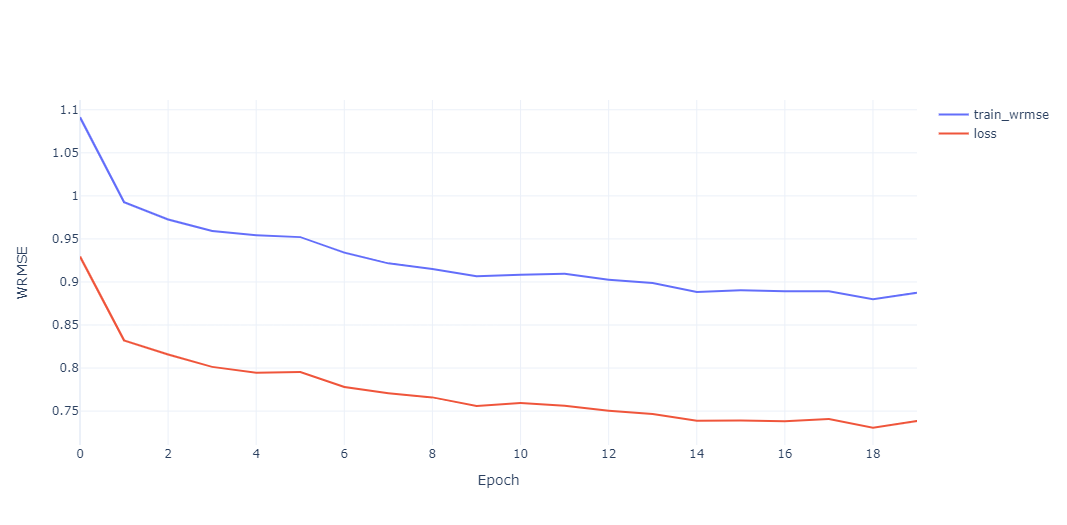

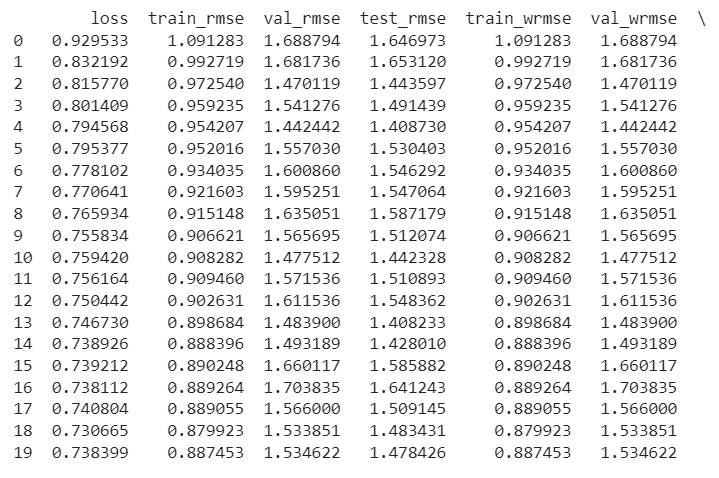

Number of epochs = 20

Learning rate = 0.01

Number of hidden channel = 16

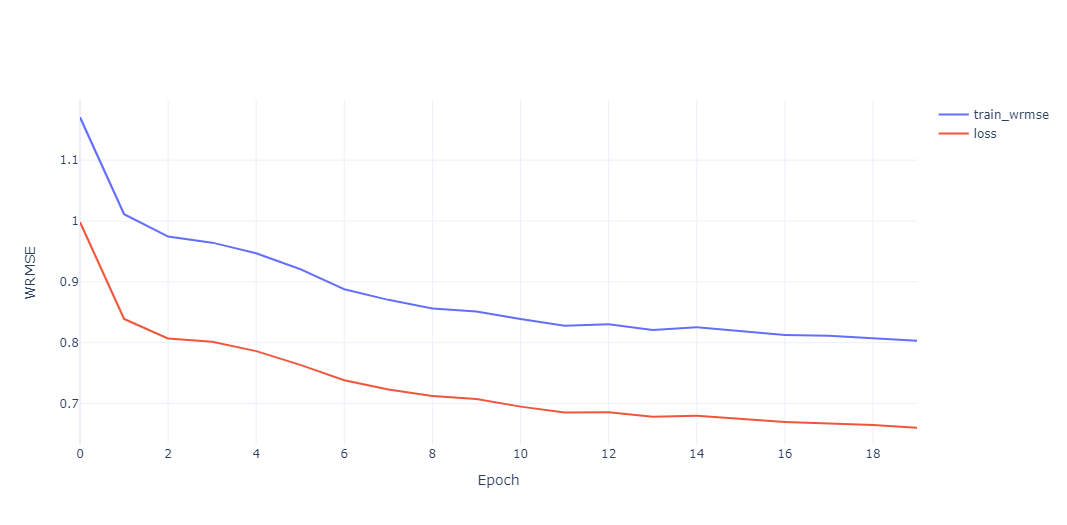

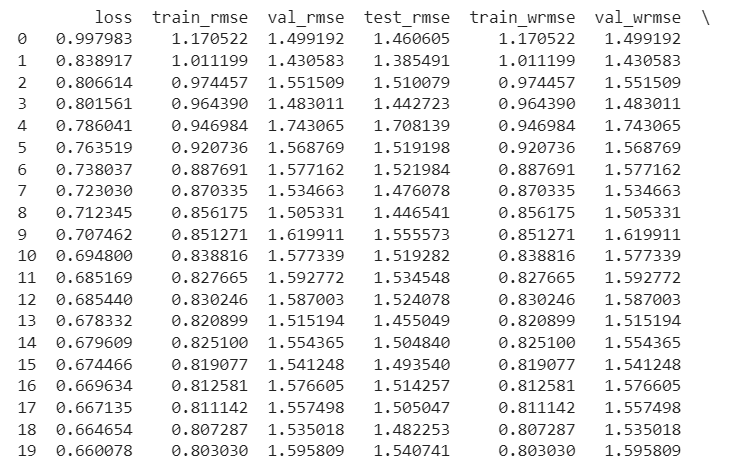

Number of epochs = 20

Learning rate = 0.01

Number of hidden channel = 32



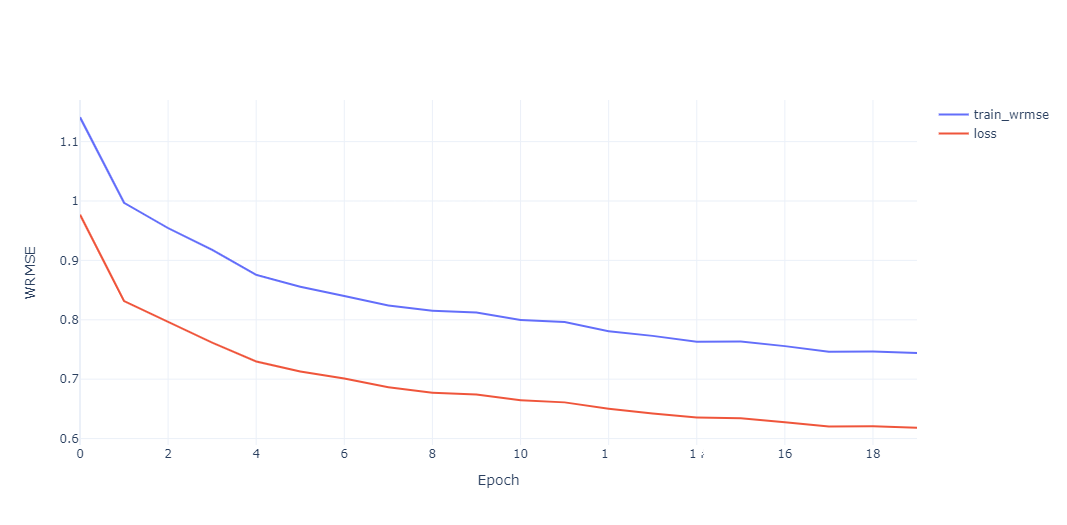

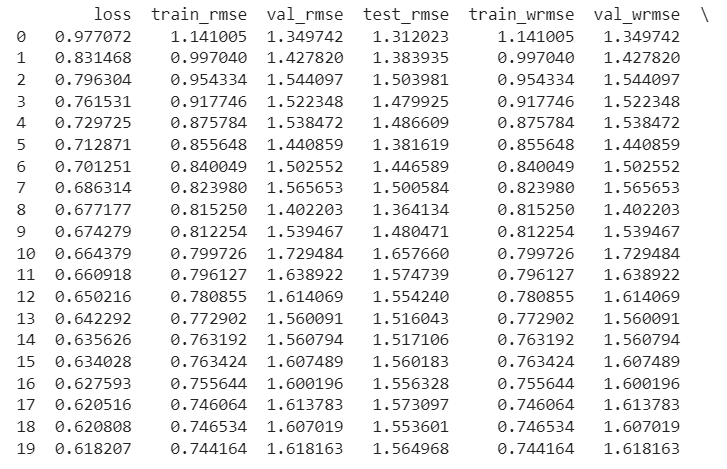

Number of epochs = 20

Learning rate = 0.05

Number of hidden channel = 32

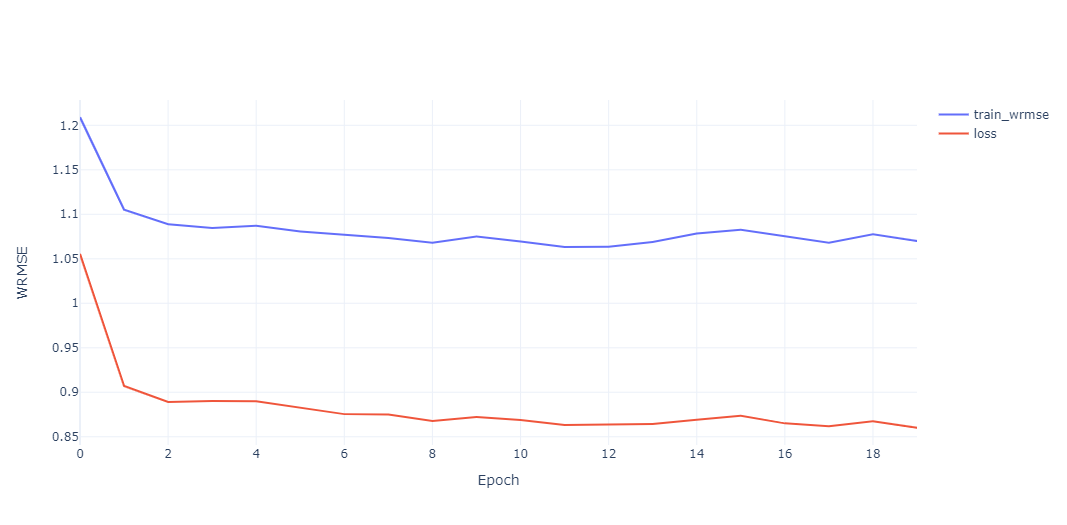

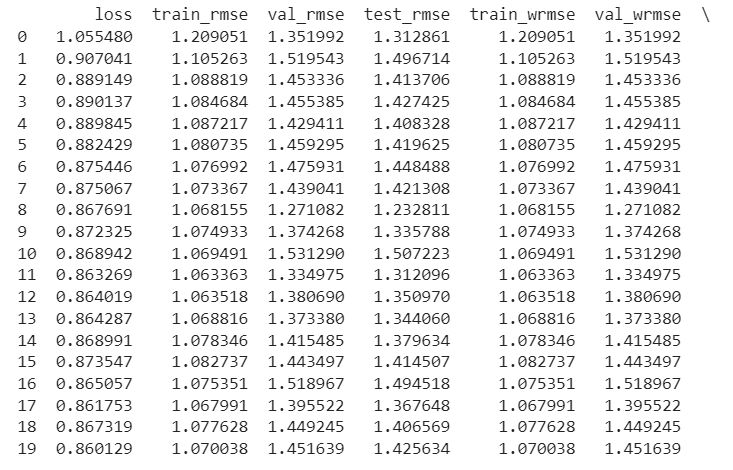

As we can see in the figures above, the loss is decreased as the number of epochs increases.

As we see here with training the model and using gnn, we get a better result.
This happens because in GNNs we keep the relations between the nodes but using just the adjacent matrix, we will lose this information. Thus, this could help us achieve a better result than the previous part.